In [2]:
import pandas as pd
import json
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
import numpy as np
from util.plot import plot_cdf, color_list,hatch_list
from collections import defaultdict 

In [3]:
_fontsize=15
def plot_map(
    bandwidth_arr,
    file_name="./figs/metric.pdf",
    xticklabels=None,
    yticklabels=None,
    enable_color_bar=True,
    fontsize=14,
    legend_name="P Error",
    rotation_x=0,
    rotation_y=0,
    fontsize_colorbar=12,
    vmax=None,
):
    # Set the style for Seaborn plots (customize as desired)
    sns.set(style="whitegrid")

    # Create a figure with a specified size
    fig = plt.figure(figsize=(5.2, 3.5))

    # Define a color palette (customize as needed)
    colormap = sns.color_palette("coolwarm", as_cmap=True)

    # Create a heatmap using Seaborn
    ax = sns.heatmap(
        bandwidth_arr,
        annot=False,  
        cmap=colormap,  # Use the defined color palette
        linewidths=0.00,  # Add grid lines
        cbar=enable_color_bar,  # Disable the color bar
        cbar_kws={"label": legend_name, "pad": 0.02},  # Customize color bar
        xticklabels=xticklabels,
        yticklabels=yticklabels if yticklabels else '',
        vmin=1.0,
        vmax=vmax
    )
    

    # Customize x-axis and y-axis tick labels, and their font properties
    ax.tick_params(axis="both", labelsize=fontsize)
    plt.xticks(rotation=rotation_x)
    plt.yticks(rotation=rotation_y)

    # Customize color bar font properties
    if enable_color_bar:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=fontsize_colorbar)
        cbar.set_label(legend_name, fontsize=fontsize_colorbar+5)

    # Save the plot as a PDF file (if a filename is provided)
    if file_name:
        plt.savefig(file_name, bbox_inches="tight", dpi=300)
data_root_path="/data1/lichenni/m3/parsimon-eval/expts/fig_8/analysis/"

In [16]:
# path performance
NR_PATHS_SAMPLED=500
N=10000
N_FLOW_THRESHOLD_LIST=[1,1,1]
mlsys_dir_list=["ns3-path-all"]
legend_list=['ns-3',"ns-3-path"]
mix_file = f'{data_root_path}../spec/deprecated/motivation.mix.json'
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./res/pre_{mlsys_dir}_{NR_PATHS_SAMPLED}_{N}_{N_FLOW_THRESHOLD_LIST[0]}.npz'
    if not os.path.exists(save_file):
        sldn_per_path_dict=defaultdict(list)
        n_flows_per_path_dict=defaultdict(list)
        n_freq_per_path_dict=defaultdict(list)
        n_link_per_path_dict=defaultdict(list)
        with open(mix_file) as f:
            mixes = json.load(f) 
        for mix_idx,mix in enumerate(mixes):
            mix_id = mix['id']
            mix_dir = f'{data_root_path}../data/{mix_id}'
            # Accuracy metrics
            df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
            
            sldn_ns3=df_ns3['slowdown']
            id_to_sldn_ns3=dict(zip(df_ns3['flow_id'],df_ns3['slowdown']))
            
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/records_{path_idx}.csv'):
                
                df_ns3_path = pd.read_csv(f'{mix_dir}/{mlsys_dir}/records_{path_idx}.csv')
                flowid_list_ns3_path=df_ns3_path['flow_id']
                sldn_ns3_path=df_ns3_path['slowdown']
                
                sldn_ns3_tmp=[id_to_sldn_ns3[flowid] for flowid in flowid_list_ns3_path]
                
                sldn_per_path=[sldn_ns3_path,sldn_ns3_tmp]
                
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_freq=int(data[-1])
                    n_freq_per_path_dict[mix_id].append(n_freq)
                    
                    n_flow_in_f=int(data[-3])
                    if n_flow_in_f<10000:
                        n_flow_in_f_prime=int(data[-2])
                        assert n_flow_in_f==len(flowid_list_ns3_path)
                        
                        n_link=len(data[0].split("|"))-1
                        
                        sldn_per_path_dict[mix_id].append(sldn_per_path)
                    
                        n_flows_per_path_dict[mix_id].append([n_flow_in_f,n_flow_in_f_prime])
                        n_link_per_path_dict[mix_id].append(n_link)
                
                print(f"mix_id: {mix_id}, path_idx: {path_idx}, len(sldn): {len(sldn_ns3_tmp)}, n_flow_in_f: {n_flow_in_f}, n_flow_in_f_prime: {n_flow_in_f_prime}, n_link: {n_link}, n_freq: {n_freq}")   
                path_idx+=1
            assert np.sum(n_freq_per_path_dict[mix_id])==NR_PATHS_SAMPLED
        np.savez(save_file, sldn_per_path_dict=sldn_per_path_dict,n_flows_per_path_dict=n_flows_per_path_dict,n_freq_per_path_dict=n_freq_per_path_dict,n_link_per_path_dict=n_link_per_path_dict)
    else:
        data=np.load(save_file, allow_pickle=True)
        sldn_per_path_dict=data['sldn_per_path_dict'].item()
        n_flows_per_path_dict=data['n_flows_per_path_dict'].item()
        n_freq_per_path_dict=data['n_freq_per_path_dict'].item()
        n_link_per_path_dict=data['n_link_per_path_dict'].item()
    

mix_id: 20, path_idx: 0, len(sldn): 458, n_flow_in_f: 458, n_flow_in_f_prime: 781918, n_link: 6, n_freq: 1
mix_id: 20, path_idx: 1, len(sldn): 452, n_flow_in_f: 452, n_flow_in_f_prime: 781767, n_link: 6, n_freq: 1
mix_id: 20, path_idx: 2, len(sldn): 448, n_flow_in_f: 448, n_flow_in_f_prime: 783192, n_link: 6, n_freq: 1
mix_id: 20, path_idx: 3, len(sldn): 437, n_flow_in_f: 437, n_flow_in_f_prime: 780124, n_link: 6, n_freq: 1
mix_id: 20, path_idx: 4, len(sldn): 436, n_flow_in_f: 436, n_flow_in_f_prime: 780845, n_link: 6, n_freq: 1
mix_id: 20, path_idx: 5, len(sldn): 436, n_flow_in_f: 436, n_flow_in_f_prime: 779204, n_link: 6, n_freq: 1
mix_id: 20, path_idx: 6, len(sldn): 432, n_flow_in_f: 432, n_flow_in_f_prime: 776863, n_link: 6, n_freq: 1
mix_id: 20, path_idx: 7, len(sldn): 431, n_flow_in_f: 431, n_flow_in_f_prime: 782839, n_link: 6, n_freq: 1
mix_id: 20, path_idx: 8, len(sldn): 428, n_flow_in_f: 428, n_flow_in_f_prime: 781467, n_link: 6, n_freq: 1
mix_id: 20, path_idx: 9, len(sldn): 4

mix_id: 20
mix_id: 179
mix_id: 12
max_idx: 5500, tmp_error: 1153.686036426713, tmp: [12.53686036  1.        ]
max_idx: 1176, tmp_error: 1151.434034416826, tmp: [12.51434034  1.        ]
max_idx: 617, tmp_error: 1025.796979865772, tmp: [11.2579698  1.       ]
max_idx: 840, tmp_error: 1111.5916955017299, tmp: [12.11591696  1.        ]
max_idx: 3071, tmp_error: 1014.7870662460567, tmp: [11.14787066  1.        ]
max_idx: 769, tmp_error: 1383.0594679186229, tmp: [14.83059468  1.        ]
max_idx: 1054, tmp_error: 1404.857363145721, tmp: [15.04857363  1.        ]
max_idx: 214, tmp_error: 1119.6208530805686, tmp: [12.18465909  0.99905303]


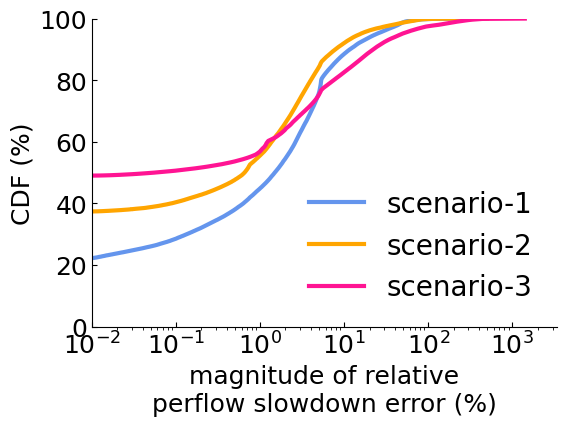

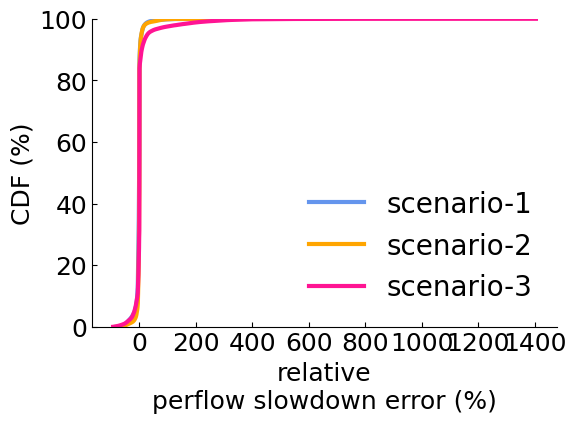

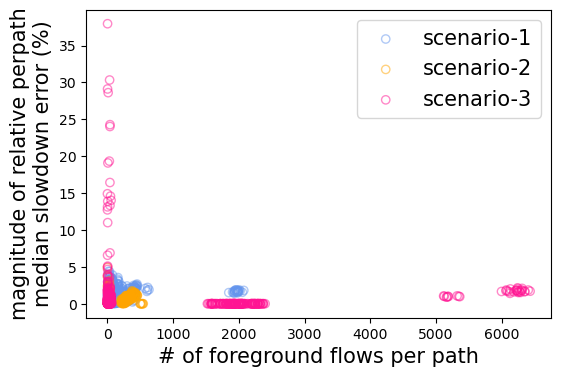

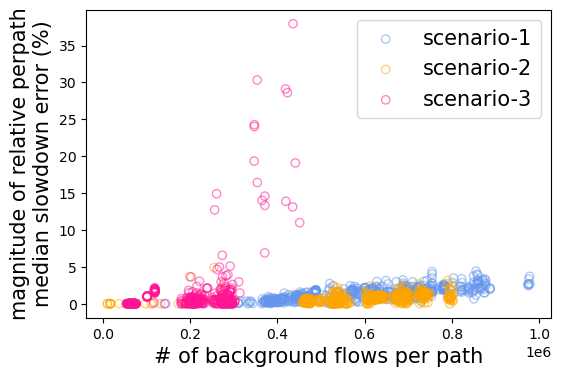

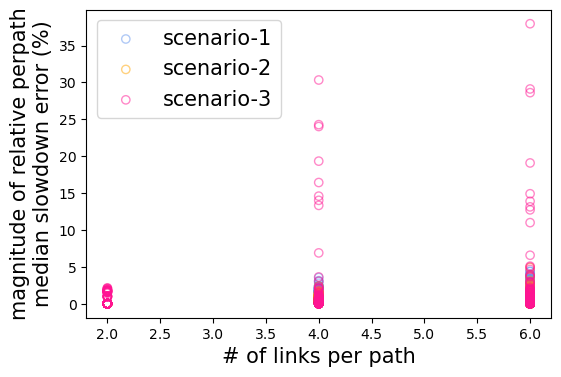

In [18]:
plot_data_per_flow=[]
plot_data_per_path=[]
plot_data_n_flows=[]
plot_data_n_link=[]
target_mix_list=[20,179,12]
plot_data_mix=[]
plot_data_per_mix=[]
plot_data_n_flow_per_mix=[]
plot_data_n_link_per_mix_sampled=[]
legend_per_mix=[]
for mix_idx,mix_id in enumerate(target_mix_list):
    print(f"mix_id: {mix_id}")
    error_real=[]
    error_abs_median=[]
    for i in range(len(sldn_per_path_dict[mix_id])):
        tmp=sldn_per_path_dict[mix_id][i]
        tmp=np.array(tmp)
        tmp_error=(tmp[0]-tmp[1])/tmp[1]*100
        if np.max(abs(tmp_error)) >1000:
            max_idx=np.argmax(abs(tmp_error))
            print(f"max_idx: {max_idx}, tmp_error: {tmp_error[max_idx]}, tmp: {tmp[:,max_idx]}")
        error_real.extend(tmp_error)
        error_abs_median.append(np.median(abs(tmp_error)))
    plot_data_per_flow.append(np.array(error_real))
    plot_data_per_path.append(np.array(error_abs_median))
plot_data_n_flows=[np.array(n_flows_per_path_dict[mix_id]) for mix_id in target_mix_list]
plot_data_n_link=[np.array(n_link_per_path_dict[mix_id]) for mix_id in target_mix_list]

fig_idx=0  
legend_mix=['scenario-1','scenario-2','scenario-3']
plot_cdf([abs(x) for x in plot_data_per_flow],None,legend_mix,'magnitude of relative\nperflow slowdown error (%)',legend_font=20,group_size=3,loc=4,rotate_xaxis=False,fontsize=18,fig_idx=fig_idx,log_switch=True,xlim_bottom=0.01)
fig_idx+=1

plot_cdf(plot_data_per_flow,None,legend_mix,'relative\nperflow slowdown error (%)',legend_font=20,group_size=3,loc=4,rotate_xaxis=False,fontsize=18,fig_idx=fig_idx,log_switch=False)
fig_idx+=1

if True:
    # print(f"plot_data: {plot_data.shape}, plot_data_n_flows: {plot_data_n_flows.shape}, plot_data_n_link: {plot_data_n_link.shape}")

    fig = plt.figure(fig_idx, figsize=(6, 4))  # Start a new figure with the specified size and index
    ax = fig.add_subplot(111)  # Add a subplot to the figure
    for i in range(len(plot_data_per_path)):
        plt.scatter(plot_data_n_flows[i][:,0],plot_data_per_path[i],marker='o',edgecolors=color_list[i],label=legend_mix[i],alpha=0.5,facecolors='none')
    plt.legend(fontsize=_fontsize)
    plt.xlabel('# of foreground flows per path', fontsize=_fontsize)
    plt.ylabel('magnitude of relative perpath\nmedian slowdown error (%)', fontsize=_fontsize)
    plt.show()
    fig_idx+=1
    
    fig = plt.figure(fig_idx, figsize=(6, 4))  # Start a new figure with the specified size and index
    ax = fig.add_subplot(111)  # Add a subplot to the figure
    for i in range(len(plot_data_per_path)):
        plt.scatter(plot_data_n_flows[i][:,1],plot_data_per_path[i],marker='o',edgecolors=color_list[i],label=legend_mix[i],alpha=0.5,facecolors='none')
    plt.legend(fontsize=_fontsize)
    plt.xlabel('# of background flows per path', fontsize=_fontsize)
    plt.ylabel('magnitude of relative perpath\nmedian slowdown error (%)', fontsize=_fontsize)
    plt.show()
    fig_idx+=1
    
    fig = plt.figure(fig_idx, figsize=(6, 4))  # Start a new figure with the specified size and index
    ax = fig.add_subplot(111)  # Add a subplot to the figure
    for i in range(len(plot_data_per_path)):
        plt.scatter(plot_data_n_link[i],plot_data_per_path[i],marker='o',edgecolors=color_list[i],label=legend_mix[i],alpha=0.5,facecolors='none')
    plt.legend(fontsize=_fontsize)
    plt.xlabel('# of links per path', fontsize=_fontsize)
    plt.ylabel('magnitude of relative perpath\nmedian slowdown error (%)', fontsize=_fontsize)
    plt.show()
    fig_idx+=1

(3, 3)


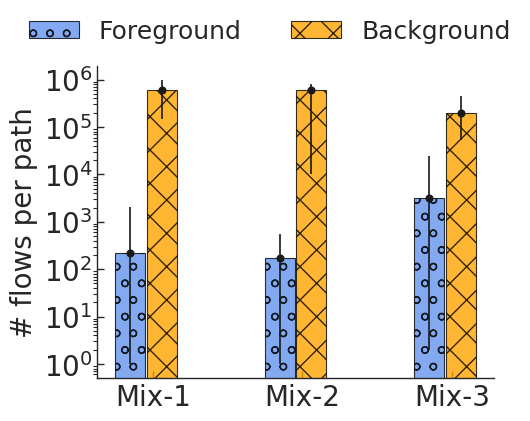

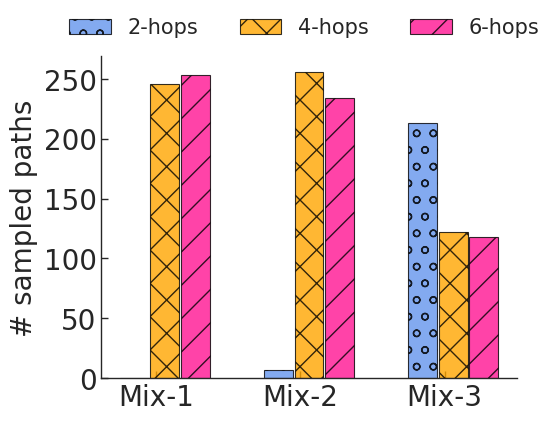

In [6]:
def plot_bar(
    datas,
    data_min,
    data_max,
    xs,
    linelabels=None,
    label=None,
    xticklabel=None,
    y_label="CDF",
    name="ss",
    log_switch=False,
    fontsize=15,
    legend_font=15,
    loc=2,
    ncol=1,
    xlim=None,
    ylim=None,
    ylim_bottom=None,
    xlim_bottom=None,
    text_x=0.04,
    text_y=0.6,
    text_font=12,
    text_rotation=-30,
    enable_text=False,
):
    _fontsize = fontsize
    fig = plt.figure(figsize=(5.2, 4))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)

    plt.ylabel(y_label, fontsize=_fontsize)
    plt.xlabel(label, fontsize=_fontsize)
    legend_target = []
    for i in range(len(datas)):
        tmp_data = datas[i]
        if data_min is not None:
            tmp_data_min = data_min[i]
            tmp_data_max = data_max[i]
        X = np.arange(0.1, 1, 1 / len(tmp_data)) + 0.07 * i
        width = 0.2 / len(tmp_data)
        tmp = ax.bar(
            X,
            tmp_data,
            color=color_list[i],
            hatch=hatch_list[i],
            edgecolor="black",
            width=width,
            alpha=0.8,
        )
        legend_target.append(tmp)
        if data_min is not None:
            ax.errorbar(
                X,
                tmp_data,
                yerr=[tmp_data - tmp_data_min, tmp_data_max - tmp_data],
                fmt="o",
                color="k",
            )
        if enable_text:
            for x, y, p in zip(X - text_x, tmp_data + text_y, tmp_data):
                plt.text(x, y, int(p), fontsize=text_font, rotation=text_rotation)
    legend_properties = {"size": legend_font}
    # handles = [
    #     plt.Rectangle((0, 0), 1, 1, color=color_list[ii]) for ii in range(len(linelabels))
    # ]

    ax.legend(
        legend_target,
        linelabels,
        loc=loc,
        ncol=ncol,
        prop=legend_properties,
        frameon=False,
        bbox_to_anchor=(1.1, 1.0),
    )

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    if xlim_bottom:
        plt.xlim(left=xlim_bottom)
    if xlim:
        plt.xlim(right=xlim)
    if ylim_bottom:
        plt.ylim(bottom=ylim_bottom)
    if ylim:
        plt.ylim(top=ylim)

    if log_switch:
        ax.set_yscale("log")

    plt.tight_layout()

    plt.tight_layout(pad=0.5, w_pad=0.01, h_pad=0.01)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(
        np.arange(0.15, 0.9, 1 / (len(datas[-1]))),
        xticklabel,
        fontsize=_fontsize,
        rotation=0,
    )
    if name:
        plt.savefig(name, bbox_inches="tight", pad_inches=0)
plot_bar(
        np.array([np.mean(x,axis=1) for x in plot_data_n_flow_per_mix]).transpose(),
        np.array([np.min(x,axis=1) for x in plot_data_n_flow_per_mix]).transpose(),
        np.array([np.max(x,axis=1) for x in plot_data_n_flow_per_mix]).transpose(),
        None,
        linelabels=["Foreground", "Background"],
        label="",
        xticklabel=["Mix-1", "Mix-2", "Mix-3"],
        y_label="# flows per path",
        name='figs/motivation_n_flows.pdf',
        log_switch=True,
        legend_font=18,
        fontsize=20,
        # ylim_bottom=0,
        # ylim=10000,
        # xlim=1,
        # xlim_bottom=0,
        text_x=0.05,
        text_y=10,
        ncol=2,
        text_font=15,
        text_rotation=0,
        loc=4,
    )
plot_data=np.array(plot_data_n_link_per_mix_sampled).transpose()
print(plot_data.shape)
plot_bar(
        plot_data,
        None,
        None,
        None,
        linelabels=["2-hops", "4-hops", "6-hops"],
        label="",
        xticklabel=["Mix-1", "Mix-2", "Mix-3"],
        y_label="# sampled paths",
        name='figs/motivation_n_links.pdf',
        log_switch=False,
        legend_font=15,
        fontsize=20,
        # ylim_bottom=0,
        # ylim=10000,
        # xlim=1,
        # xlim_bottom=0,
        text_x=0.03,
        text_y=10,
        ncol=3,
        text_font=13,
        text_rotation=0,
        loc=4,
        enable_text=False,
    )


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


        mix  n_link      error           n_flow       kind
0     mix-1       6   0.325768       [100, 500)  ns-3-path
1     mix-1       6   0.012532       [100, 500)  ns-3-path
2     mix-1       6   2.621550       [100, 500)  ns-3-path
3     mix-1       6  14.101756       [100, 500)  ns-3-path
4     mix-1       6   2.188055       [100, 500)  ns-3-path
...     ...     ...        ...              ...        ...
1444  mix-3       2  -2.866882  [500, $\infty$)  ns-3-path
1445  mix-3       2   3.341750  [500, $\infty$)  ns-3-path
1446  mix-3       2  -2.945058  [500, $\infty$)  ns-3-path
1447  mix-3       2  -2.052252  [500, $\infty$)  ns-3-path
1448  mix-3       2  -7.519400  [500, $\infty$)  ns-3-path

[1449 rows x 5 columns]


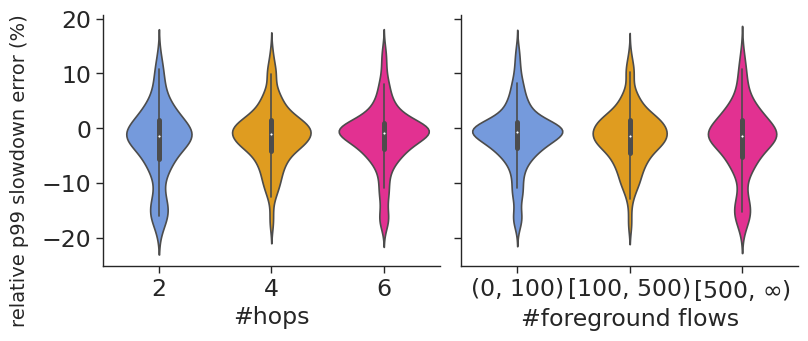

In [7]:
fontsize=17
def remove_outliers(data, column, threshold=1.5):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

def violins(df):
    xs_labels_orders_rot = [
        # ('mix', 'Various mixes', ['mix-1', 'mix-2', 'mix-3'], 0),
        ('n_link', '#hops', [2, 4, 6], 0),
        ('n_flow', '#foreground flows', ['(0, 100)', '[100, 500)', '[500, $\infty$)'], 0),
    ]
    legend_loc_list=['upper left','upper right']
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.2, 3.5), sharey=True)

    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):

        # Create a list of colors for each violin
        # colors = [f'C{i}' for i in range(len(df['kind'].unique()))]

        filtered_df = df[df[x].isin(order)]
        filtered_df = remove_outliers(filtered_df, 'error', threshold=2)

        ax = sns.violinplot(
            data=filtered_df,
            x=x,
            y='error',
            # hue='kind',
            order=order,
            ax=axs[i],
            split=True,
            palette=color_list,
        )
        ax.set_xlabel(label,fontsize=fontsize)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
            tick.set_fontsize(fontsize)
        for tick in ax.get_yticklabels():
            tick.set_fontsize(fontsize)
        ax.set_ylabel('')
    # Remove "kind" from the legend
    for idx,ax in enumerate(axs.flat):
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles=handles[0:], labels=labels[0:],frameon=False,loc=legend_loc_list[idx],prop={"size": 18})
    sns.despine()
    
    fig.supylabel('relative p99 slowdown error (%)',fontsize=fontsize-3)
    fig.tight_layout()

# Assuming records and 'kind' column are defined somewhere in your script
n_flow_str_list=[] 
for n_flow in plot_data_n_flows[0]:
    if n_flow<100:
        n_flow_str_list.append('(0, 100)')
    elif n_flow<500:
        n_flow_str_list.append('[100, 500)')
    else:
        n_flow_str_list.append('[500, $\infty$)')
df_ns3_path = pd.DataFrame({
    'mix': plot_data_mix,
    'n_link': plot_data_n_link,
    'error': error_real[0]*100,
    'n_flow': n_flow_str_list,
})

df_pmn = pd.DataFrame({
    'mix': plot_data_mix, # 'Various mixes
    'n_link': plot_data_n_link,
    'error': error_real[1]*100,
    'n_flow': n_flow_str_list,
})

df_ns3_path['kind'] = 'ns-3-path'
df_pmn['kind'] = 'Parsimon' 
df_violin = pd.concat([df_ns3_path,df_pmn], ignore_index=True)
df_violin=df_ns3_path
print(df_violin)
violins(df_violin)
plt.savefig('figs/motivation_violin.pdf', bbox_inches='tight')


In [29]:
def plot_map(
    bandwidth_arr,
    file_name="./figs/metric.pdf",
    xticklabels=None,
    yticklabels=None,
    enable_color_bar=True,
    fontsize=40,
    legend_name="P Error",
    labelpad=-230,
    fontsize_x=45,
    rotation_x=30,
    fontsize_y=45,
    rotation_y=0,
    fontsize_colorbar=50,
):
    fig = plt.figure(figsize=(5.2,3))  # 2.5 inch for 1/3 double column width
   
    colormap = sns.color_palette("ch:s=.25,rot=-.25")
    ax = sns.heatmap(
        bandwidth_arr,
        # mask=mask,
        # squre=True,
        annot=False,
        fmt=".2f",
        annot_kws={"size": fontsize},
        # cbar_kws={"label": "Network Bandwidth (Mibit/s)"},
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        # cmap=colormap,
        linewidth=0.,
        # square=True
    )
    
    if enable_color_bar:
        cbar = ax.collections[0].colorbar
        cbar.set_label(legend_name, labelpad=labelpad)
        cbar.ax.tick_params(labelsize=fontsize)
        cbar.ax.yaxis.label.set_size(fontsize_colorbar+5)
    plt.xticks(fontsize=fontsize_x, rotation=rotation_x)
    plt.yticks(fontsize=fontsize_y, rotation=rotation_y)

    # plt.tight_layout()
    if file_name:
        plt.savefig(file_name, bbox_inches="tight") 


In [30]:
# [FINAL] no post-processing, cdf of p99 SLOWDOWN, get the mean slowdown across size buckets and then calculate the error percentage
MTU=1000
dir_input_synthetic="/data2/lichenni/path/input"
topo_type="_topo-pl-x-x_dctcp"
lr=10
# P99_PERCENTILE_LIST = P99_PERCENTILE_LIST = np.array(
#     [10, 20, 30, 40, 50, 60, 70, 75, 80, 85, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
# )
P99_PERCENTILE_LIST = P99_PERCENTILE_LIST = np.arange(1,101,1)
SIZE_BUCKET_LIST_LABEL=[
    "(0, 250B)",
    "(250B, 500B)",
    "(500B, 750B)",
    "(750B, 1KB)",
    "(1KB, 2KB)",
    "(2KB, 5KB)",
    "(5KB, 7.5KB)",
    "(7.5KB, 10KB)",
    "(10KB, 50KB)",
    "(50KB, INF)",
]
BDP_DICT = {
    2: 10.5 * MTU,
    3: 14 * MTU,
    4: 17.5 * MTU,
    5: 21 * MTU,
    6: 24.5 * MTU,
    7: 28 * MTU,
    8: 31.5 * MTU,
    9: 34 * MTU,
}
SIZE_BUCKET_LIST_LABEL_OUTPUT = ["(0, MTU)", "(MTU, BDP)", "(BDP, 5BDP)", "(5BDP, INF)"]
DELAY_PROPAGATION_BASE = 1000  # 1us
HEADER_SIZE = 48
BYTE_TO_BIT = 8

def get_size_bucket_list_output(mtu, bdp):
    return np.array([mtu, bdp, 5 * bdp])

def get_size_bucket_list(mtu, bdp):
    return np.array(
        [
            mtu // 4,
            mtu // 2,
            mtu * 3 // 4,
            mtu,
            bdp // 5,
            bdp // 2,
            bdp * 3 // 4,
            bdp,
            5 * bdp,
        ]
    )
def decode_dict(d, encoding_used="utf-8"):
    return {
        k.decode(encoding_used): (
            v.decode(encoding_used) if isinstance(v, bytes) else v
        )
        for k, v in d.items()
    }

yticklabels=SIZE_BUCKET_LIST_LABEL
xticklabels = [f"{x}%" if x % 20 == 0 else None for x in np.arange(1, 101, 1)]
x_len = len(SIZE_BUCKET_LIST_LABEL)
x_len_output = len(SIZE_BUCKET_LIST_LABEL_OUTPUT)
y_len = len(P99_PERCENTILE_LIST)
lr=10
    
dir_output="/data2/lichenni/output_1116"
program_name_list=['m3_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps',
                   ]
version_id_list=[
    [0],[0]
]

enable_abs = False
title_str_list = ["ns-3","flowSim","flowSim-samp", "Ours"]
main_title_list=['train','test','empirical']
fig_index=0
version_id_test=1

loc='lower right'

for program_name_idx,program_name in enumerate(program_name_list):
    for version_id in version_id_list[program_name_idx]:
        dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
        if version_id_test==0 or version_id_test==1:
            f = open(f"{dir_train}/data_list.json", "r")
            data_list = json.loads(f.read())
            if version_id_test==0:
                data_list_test=data_list["train"]
                data_list_test_idx=np.random.choice(np.arange(len(data_list_test)),size=len(data_list_test)//10,replace=False)
                data_list_test=[data_list_test[i] for i in data_list_test_idx]
            else:
                data_list_test=[]
                for spec_idx in range(len(data_list["test"])):
                    spec,src_dst_pair_target,topo_type =data_list["test"][spec_idx]
                    tmp = spec.split("_")
                    n_hosts=int(tmp[2][6:])
                    if n_hosts==2:
                        data_list_test.append(data_list["test"][spec_idx])
                
                
            dir_input=dir_input_synthetic
        
        len_tracks=len(data_list_test)
        print(f"{program_name} loads {len_tracks} tracks")
        for spec_idx,spec_id in enumerate([20,153,177]):
            spec,src_dst_pair_target,topo_type =data_list_test[spec_id]
            print(f"spec: {spec},{src_dst_pair_target},{topo_type}")
            src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
            data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}_{src_dst_pair_target_str}/res.npz')
            sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
            
            tmp = spec.split("_")
            n_hosts=int(tmp[2][6:])
            BDP=BDP_DICT[n_hosts]
            size_bucket_list = get_size_bucket_list(mtu=MTU,bdp=BDP)

            flow_src_dst = np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
            sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
            fcts=np.load(f'{dir_input}/{spec}/fcts{topo_type}.npy')
            i_fcts=np.load(f'{dir_input}/{spec}/i_fcts{topo_type}.npy')
            sldns=np.divide(fcts, i_fcts)
            
            stats=decode_dict(np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True,encoding="bytes").item())
            
            n_links_passed=abs(src_dst_pair_target[0]-src_dst_pair_target[1])+2
            
            i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION_BASE*n_links_passed
            fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+DELAY_PROPAGATION_BASE*n_links_passed
            sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
            
            flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
            sizes=sizes[flow_idx_target]
            sldns_flowsim=sldns_flowsim[flow_idx_target]
            sldns=sldns[flow_idx_target]
            bins=np.digitize(sizes,size_bucket_list)

            heat_map=np.zeros((x_len,y_len))
            for x_idx in range(x_len):
                sldn_idx_target = np.nonzero(bins == x_idx)[0]
                if len(sldn_idx_target) < 1:
                    continue
                sldns_flowsim_tmp = sldns_flowsim[sldn_idx_target]
                heat_map[x_idx]=np.percentile(sldns_flowsim_tmp, P99_PERCENTILE_LIST)
            heat_map[heat_map==0]=None
            plot_map(
                heat_map,
                file_name=f'figs/motivation_heatmap_burstiness_{spec_idx}.pdf',
                xticklabels=xticklabels,
                yticklabels=yticklabels if spec_idx==0 else None,
                enable_color_bar=True if spec_idx==2 else False,
                fontsize_colorbar=15,
                fontsize=15,
                legend_name="FCT slowdown",
                rotation_x=0,
                rotation_y=0,
                vmax=5
            )
        for spec_idx,spec_id in enumerate([104,29,119]):
            spec,src_dst_pair_target,topo_type =data_list_test[spec_id]
            print(f"spec: {spec},{src_dst_pair_target},{topo_type}")
            src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
            data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}_{src_dst_pair_target_str}/res.npz')
            sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
            
            tmp = spec.split("_")
            n_hosts=int(tmp[2][6:])
            BDP=BDP_DICT[n_hosts]
            size_bucket_list = get_size_bucket_list(mtu=MTU,bdp=BDP)

            flow_src_dst = np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
            sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
            fcts=np.load(f'{dir_input}/{spec}/fcts{topo_type}.npy')
            i_fcts=np.load(f'{dir_input}/{spec}/i_fcts{topo_type}.npy')
            sldns=np.divide(fcts, i_fcts)
            
            stats=decode_dict(np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True,encoding="bytes").item())
            
            n_links_passed=abs(src_dst_pair_target[0]-src_dst_pair_target[1])+2
            
            i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION_BASE*n_links_passed
            fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+DELAY_PROPAGATION_BASE*n_links_passed
            sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
            
            flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
            sizes=sizes[flow_idx_target]
            sldns_flowsim=sldns_flowsim[flow_idx_target]
            sldns=sldns[flow_idx_target]
            bins=np.digitize(sizes,size_bucket_list)

            heat_map=np.zeros((x_len,y_len))
            for x_idx in range(x_len):
                sldn_idx_target = np.nonzero(bins == x_idx)[0]
                if len(sldn_idx_target) < 1:
                    continue
                sldns_flowsim_tmp = sldns_flowsim[sldn_idx_target]
                heat_map[x_idx]=np.percentile(sldns_flowsim_tmp, P99_PERCENTILE_LIST)
            heat_map[heat_map==0]=None
            plot_map(
                heat_map,
                file_name=f'figs/motivation_heatmap_load_{spec_idx}.pdf',
                xticklabels=xticklabels,
                yticklabels=yticklabels if spec_idx==0 else None,
                enable_color_bar=True if spec_idx==2 else False,
                fontsize_colorbar=15,
                fontsize=15,
                legend_name="FCT slowdown",
                rotation_x=0,
                rotation_y=0,
                vmax=5
            )
        for spec_idx,spec_id in enumerate([97,72,93]):
            spec,src_dst_pair_target,topo_type =data_list_test[spec_id]
            print(f"spec: {spec},{src_dst_pair_target},{topo_type}")
            src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
            data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}_{src_dst_pair_target_str}/res.npz')
            sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
            
            tmp = spec.split("_")
            n_hosts=int(tmp[2][6:])
            BDP=BDP_DICT[n_hosts]
            size_bucket_list = get_size_bucket_list(mtu=MTU,bdp=BDP)

            flow_src_dst = np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
            sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
            fcts=np.load(f'{dir_input}/{spec}/fcts{topo_type}.npy')
            i_fcts=np.load(f'{dir_input}/{spec}/i_fcts{topo_type}.npy')
            sldns=np.divide(fcts, i_fcts)
            
            stats=decode_dict(np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True,encoding="bytes").item())
            
            n_links_passed=abs(src_dst_pair_target[0]-src_dst_pair_target[1])+2
            
            i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION_BASE*n_links_passed
            fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+DELAY_PROPAGATION_BASE*n_links_passed
            sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
            
            flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
            sizes=sizes[flow_idx_target]
            sldns_flowsim=sldns_flowsim[flow_idx_target]
            sldns=sldns[flow_idx_target]
            bins=np.digitize(sizes,size_bucket_list)

            heat_map=np.zeros((x_len,y_len))
            for x_idx in range(x_len):
                sldn_idx_target = np.nonzero(bins == x_idx)[0]
                if len(sldn_idx_target) < 1:
                    continue
                sldns_flowsim_tmp = sldns_flowsim[sldn_idx_target]
                heat_map[x_idx]=np.percentile(sldns_flowsim_tmp, P99_PERCENTILE_LIST)
            heat_map[heat_map==0]=None
            plot_map(
                heat_map,
                file_name=f'figs/motivation_heatmap_workload_{spec_idx}.pdf',
                xticklabels=xticklabels,
                yticklabels=yticklabels if spec_idx==0 else None,
                enable_color_bar=True if spec_idx==2 else False,
                fontsize_colorbar=15,
                fontsize=15,
                legend_name="FCT slowdown",
                rotation_x=0,
                rotation_y=0,
                vmax=5
            )

m3_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps loads 304 tracks
spec: shard1130_nflows30000_nhosts2_lr10Gbps,[0, 1],_topo-pl-2-2_dctcp


FileNotFoundError: [Errno 2] No such file or directory: '/data2/lichenni/path/input/shard1130_nflows30000_nhosts2_lr10Gbps/flow_src_dst.npy'

In [8]:

for spec_idx in range(len(data_list_test)):
    spec,src_dst_pair_target,topo_type =data_list_test[spec_idx]
    stats=decode_dict(np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True,encoding="bytes").item())
    
    # if stats['size_dist_candidates'][0]==b'pareto' and 0.45<stats['load_bottleneck_target']<0.55:
    #     print(f"spec: {spec_idx}, {stats['ias_sigma_candidates']}")
    
    if 0.45<stats['load_bottleneck_target']<0.55 and 1.4<stats['ias_sigma_candidates']<1.6:
        print(f"spec: {spec_idx}, {stats['size_dist_candidates'][0]}")
    
    # print(f"find burstiness")

NameError: name 'data_list_test' is not defined

In [4]:
def decode_dict(d, encoding_used="utf-8"):
    return {
        k.decode(encoding_used): (
            v.decode(encoding_used) if isinstance(v, bytes) else v
        )
        for k, v in d.items()
    }
dir_input='/data2/lichenni/path_empirical'
topo_type="_topo-pl-x_dctcp_k30"
lr=10
data_list_test=[]
for shard in np.arange(50):
    for n_flows in [20000]:
        for n_hosts in [3]:
            topo_type_cur=topo_type.replace("-x_",f"-{n_hosts}_")
            spec=f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
            dir_input_tmp = f"{dir_input}/{spec}"
            if not os.path.exists(f'{dir_input_tmp}/flow_src_dst.npy'): continue
            flow_src_dst = np.load(f'{dir_input_tmp}/flow_src_dst.npy')
            stats=decode_dict(np.load(f'{dir_input_tmp}/stats.npy', allow_pickle=True,encoding="bytes").item())
            n_flows_total=stats["n_flows"]
            if len(flow_src_dst)==n_flows_total:
                data_list_test.append((spec,(0,n_hosts-1),topo_type_cur))
print(f"len(data_list): {len(data_list_test)}")                

len(data_list): 50


In [5]:

for spec_idx in range(len(data_list_test)):
    spec,src_dst_pair_target,topo_type =data_list_test[spec_idx]
    stats=decode_dict(np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True,encoding="bytes").item())
    # print(f"spec: {spec_idx}, {stats}")
    # if stats['size_dist_candidate']=='cachefollower-all' and stats['ias_sigma_candidate']==1.5:
    #     print(f"spec: {spec_idx}, {stats['load_bottleneck_target']}")
        
    # if stats['size_dist_candidate']=='cachefollower-all' and stats['load_bottleneck_target']==0.5:
    #     print(f"spec: {spec_idx}, {stats['ias_sigma_candidate']}")
    
    if 0.45<stats['load_bottleneck_target']==0.5 and stats['ias_sigma_candidate']==1.5:
        print(f"spec: {spec_idx}, {stats['size_dist_candidate']}")
    
    # print(f"find burstiness")
    

spec: 4, webserver-all
spec: 8, cachefollower-all
spec: 11, cachefollower-all
spec: 12, webserver-all
spec: 16, webserver-all
spec: 24, cachefollower-all
spec: 30, hadoop-all
spec: 43, cachefollower-all


loads 50 tracks
spec: shard1_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30
spec: shard24_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30
spec: shard9_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30
spec: shard3_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30
spec: shard24_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30
spec: shard18_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30
spec: shard30_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30
spec: shard24_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30
spec: shard4_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30


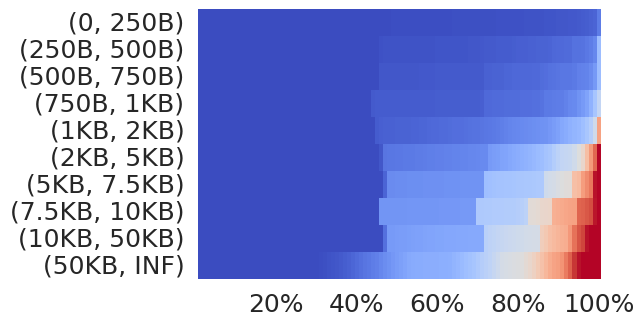

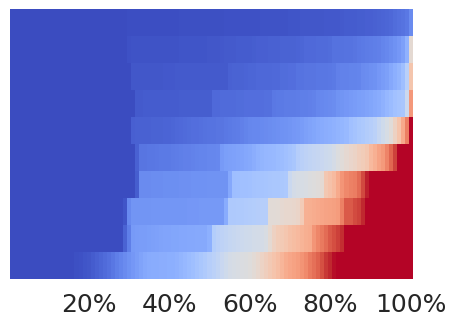

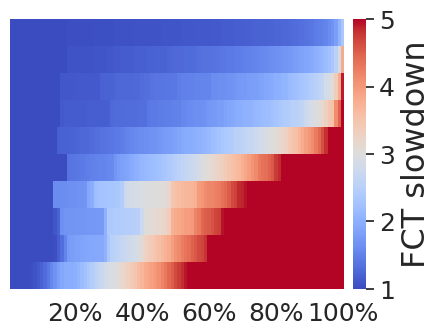

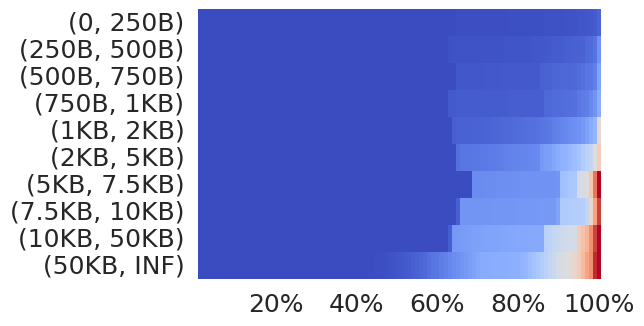

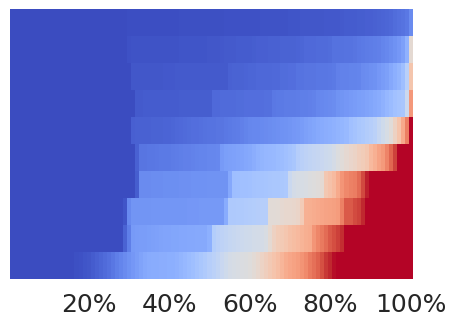

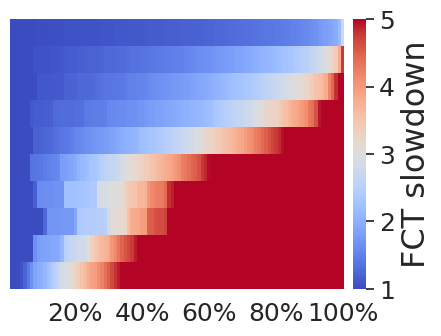

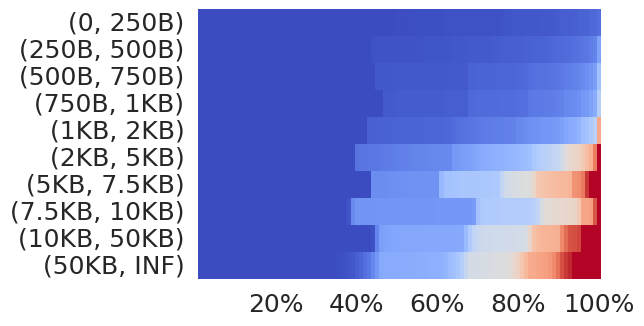

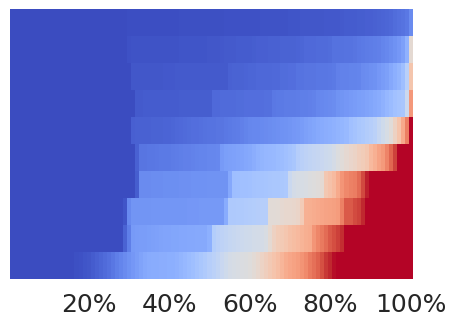

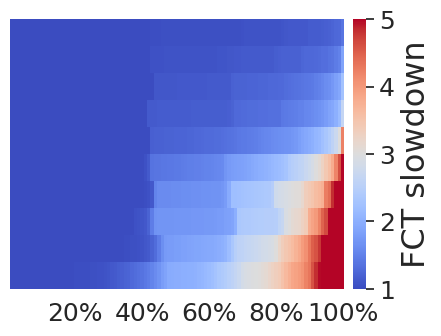

In [6]:
load_list=[3,24,18]
burstiness_list=[1,24,9]
workload_list=[30,24,4]
# [FINAL] no post-processing, cdf of p99 SLOWDOWN, get the mean slowdown across size buckets and then calculate the error percentage
MTU=1000
topo_type="_topo-pl-x-x_dctcp"
lr=10
# P99_PERCENTILE_LIST = P99_PERCENTILE_LIST = np.array(
#     [10, 20, 30, 40, 50, 60, 70, 75, 80, 85, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
# )
P99_PERCENTILE_LIST = P99_PERCENTILE_LIST = np.arange(1,101,1)
SIZE_BUCKET_LIST_LABEL=[
    "(0, 250B)",
    "(250B, 500B)",
    "(500B, 750B)",
    "(750B, 1KB)",
    "(1KB, 2KB)",
    "(2KB, 5KB)",
    "(5KB, 7.5KB)",
    "(7.5KB, 10KB)",
    "(10KB, 50KB)",
    "(50KB, INF)",
]
BDP_DICT = {
    2: 10.5 * MTU,
    3: 14 * MTU,
    4: 17.5 * MTU,
    5: 21 * MTU,
    6: 24.5 * MTU,
    7: 28 * MTU,
    8: 31.5 * MTU,
    9: 34 * MTU,
}
SIZE_BUCKET_LIST_LABEL_OUTPUT = ["(0, MTU)", "(MTU, BDP)", "(BDP, 5BDP)", "(5BDP, INF)"]
DELAY_PROPAGATION_BASE = 1000  # 1us
HEADER_SIZE = 48
BYTE_TO_BIT = 8

def get_size_bucket_list_output(mtu, bdp):
    return np.array([mtu, bdp, 5 * bdp])

def get_size_bucket_list(mtu, bdp):
    return np.array(
        [
            mtu // 4,
            mtu // 2,
            mtu * 3 // 4,
            mtu,
            bdp // 5,
            bdp // 2,
            bdp * 3 // 4,
            bdp,
            5 * bdp,
        ]
    )

yticklabels=SIZE_BUCKET_LIST_LABEL
xticklabels = [f"{x}%" if x % 20 == 0 else None for x in np.arange(1, 101, 1)]
x_len = len(SIZE_BUCKET_LIST_LABEL)
x_len_output = len(SIZE_BUCKET_LIST_LABEL_OUTPUT)
y_len = len(P99_PERCENTILE_LIST)
lr=10
    
title_str_list = ["ns-3","flowSim","flowSim-samp", "Ours"]
fig_index=0

loc='lower right'
_fontsize=18
len_tracks=len(data_list_test)
print(f"loads {len_tracks} tracks")
for spec_idx,spec_id in enumerate(burstiness_list):
    spec,src_dst_pair_target,topo_type =data_list_test[spec_id]
    print(f"spec: {spec},{src_dst_pair_target},{topo_type}")
    src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
    
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    BDP=BDP_DICT[n_hosts]
    size_bucket_list = get_size_bucket_list(mtu=MTU,bdp=BDP)

    flow_src_dst = np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
    sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
    
    stats=decode_dict(np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True,encoding="bytes").item())
    
    n_links_passed=abs(src_dst_pair_target[0]-src_dst_pair_target[1])+2
    
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION_BASE*n_links_passed
    fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+DELAY_PROPAGATION_BASE*n_links_passed
    sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
    
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    sizes=sizes[flow_idx_target]
    sldns_flowsim=sldns_flowsim[flow_idx_target]
    bins=np.digitize(sizes,size_bucket_list)

    heat_map=np.zeros((x_len,y_len))
    for x_idx in range(x_len):
        sldn_idx_target = np.nonzero(bins == x_idx)[0]
        if len(sldn_idx_target) < 1:
            continue
        sldns_flowsim_tmp = sldns_flowsim[sldn_idx_target]
        heat_map[x_idx]=np.percentile(sldns_flowsim_tmp, P99_PERCENTILE_LIST)
    heat_map[heat_map==0]=None
    plot_map(
        heat_map,
        file_name=f'figs/motivation_heatmap_burstiness_empirical_{spec_idx}.pdf',
        xticklabels=xticklabels,
        yticklabels=yticklabels if spec_idx==0 else None,
        enable_color_bar=True if spec_idx==2 else False,
        fontsize_colorbar=_fontsize,
        fontsize=_fontsize,
        legend_name="FCT slowdown",
        rotation_x=0,
        rotation_y=0,
        vmax=5
    )
for spec_idx,spec_id in enumerate(load_list):
    spec,src_dst_pair_target,topo_type =data_list_test[spec_id]
    print(f"spec: {spec},{src_dst_pair_target},{topo_type}")
    src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
    
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    BDP=BDP_DICT[n_hosts]
    size_bucket_list = get_size_bucket_list(mtu=MTU,bdp=BDP)

    flow_src_dst = np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
    sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
    
    stats=decode_dict(np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True,encoding="bytes").item())
    
    n_links_passed=abs(src_dst_pair_target[0]-src_dst_pair_target[1])+2
    
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION_BASE*n_links_passed
    fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+DELAY_PROPAGATION_BASE*n_links_passed
    sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
    
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    sizes=sizes[flow_idx_target]
    sldns_flowsim=sldns_flowsim[flow_idx_target]
    bins=np.digitize(sizes,size_bucket_list)

    heat_map=np.zeros((x_len,y_len))
    for x_idx in range(x_len):
        sldn_idx_target = np.nonzero(bins == x_idx)[0]
        if len(sldn_idx_target) < 1:
            continue
        sldns_flowsim_tmp = sldns_flowsim[sldn_idx_target]
        heat_map[x_idx]=np.percentile(sldns_flowsim_tmp, P99_PERCENTILE_LIST)
    heat_map[heat_map==0]=None
    plot_map(
        heat_map,
        file_name=f'figs/motivation_heatmap_load_empirical_{spec_idx}.pdf',
        xticklabels=xticklabels,
        yticklabels=yticklabels if spec_idx==0 else None,
        enable_color_bar=True if spec_idx==2 else False,
        fontsize_colorbar=_fontsize,
        fontsize=_fontsize,
        legend_name="FCT slowdown",
        rotation_x=0,
        rotation_y=0,
        vmax=5
    )
for spec_idx,spec_id in enumerate(workload_list):
    spec,src_dst_pair_target,topo_type =data_list_test[spec_id]
    print(f"spec: {spec},{src_dst_pair_target},{topo_type}")
    src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
    
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    BDP=BDP_DICT[n_hosts]
    size_bucket_list = get_size_bucket_list(mtu=MTU,bdp=BDP)

    flow_src_dst = np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
    sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
    
    stats=decode_dict(np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True,encoding="bytes").item())
    
    n_links_passed=abs(src_dst_pair_target[0]-src_dst_pair_target[1])+2
    
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION_BASE*n_links_passed
    fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+DELAY_PROPAGATION_BASE*n_links_passed
    sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
    
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    sizes=sizes[flow_idx_target]
    sldns_flowsim=sldns_flowsim[flow_idx_target]
    bins=np.digitize(sizes,size_bucket_list)

    heat_map=np.zeros((x_len,y_len))
    for x_idx in range(x_len):
        sldn_idx_target = np.nonzero(bins == x_idx)[0]
        if len(sldn_idx_target) < 1:
            continue
        sldns_flowsim_tmp = sldns_flowsim[sldn_idx_target]
        heat_map[x_idx]=np.percentile(sldns_flowsim_tmp, P99_PERCENTILE_LIST)
    heat_map[heat_map==0]=None
    plot_map(
        heat_map,
        file_name=f'figs/motivation_heatmap_workload_empirical_{spec_idx}.pdf',
        xticklabels=xticklabels,
        yticklabels=yticklabels if spec_idx==0 else None,
        enable_color_bar=True if spec_idx==2 else False,
        fontsize_colorbar=_fontsize,
        fontsize=_fontsize,
        legend_name="FCT slowdown",
        rotation_x=0,
        rotation_y=0,
        vmax=5
    )

loads 50 tracks
spec: shard18_nflows20000_nhosts3_lr10Gbps,(0, 2),_topo-pl-3_dctcp_k30
(4, 101)


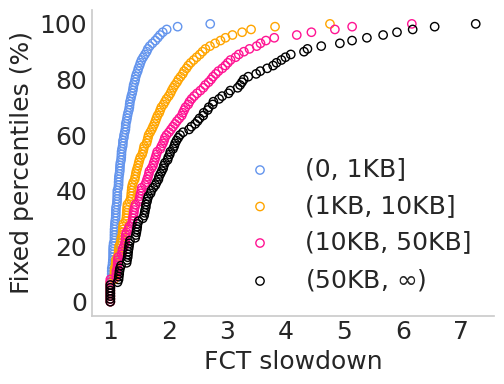

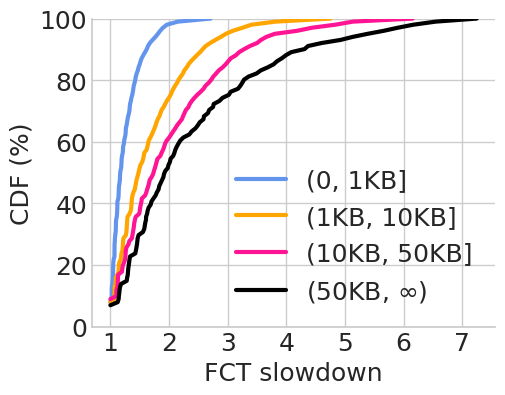

In [8]:
# [FINAL] no post-processing, cdf of p99 SLOWDOWN, get the mean slowdown across size buckets and then calculate the error percentage
MTU=1000
topo_type="_topo-pl-x-x_dctcp"
lr=10
# P99_PERCENTILE_LIST = P99_PERCENTILE_LIST = np.array(
#     [10, 20, 30, 40, 50, 60, 70, 75, 80, 85, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
# )
P99_PERCENTILE_LIST = P99_PERCENTILE_LIST = np.arange(0,101,1)
SIZE_BUCKET_LIST_LABEL=[
    "(0, 250B)",
    "(250B, 500B)",
    "(500B, 750B)",
    "(750B, 1KB)",
    "(1KB, 2KB)",
    "(2KB, 5KB)",
    "(5KB, 7.5KB)",
    "(7.5KB, 10KB)",
    "(10KB, 50KB)",
    "(50KB, INF)",
]
BDP_DICT = {
    2: 10.5 * MTU,
    3: 14 * MTU,
    4: 17.5 * MTU,
    5: 21 * MTU,
    6: 24.5 * MTU,
    7: 28 * MTU,
    8: 31.5 * MTU,
    9: 34 * MTU,
}
SIZE_BUCKET_LIST_LABEL_OUTPUT = ["(0, 1KB]", "(1KB, 10KB]", "(10KB, 50KB]", "(50KB, $\infty$)"]
DELAY_PROPAGATION_BASE = 1000  # 1us
HEADER_SIZE = 48
BYTE_TO_BIT = 8

def get_size_bucket_list_output(mtu, bdp):
    return np.array([mtu, bdp, 5 * bdp])

def get_size_bucket_list(mtu, bdp):
    return np.array(
        [
            mtu // 4,
            mtu // 2,
            mtu * 3 // 4,
            mtu,
            bdp // 5,
            bdp // 2,
            bdp * 3 // 4,
            bdp,
            5 * bdp,
        ]
    )

yticklabels=SIZE_BUCKET_LIST_LABEL
xticklabels = [f"{x}%" if x % 20 == 0 else None for x in np.arange(1, 101, 1)]
x_len = len(SIZE_BUCKET_LIST_LABEL)
x_len_output = len(SIZE_BUCKET_LIST_LABEL_OUTPUT)
y_len = len(P99_PERCENTILE_LIST)
lr=10
    
title_str_list = ["ns-3"]
fig_index=0

loc='lower right'
_fontsize=18
len_tracks=len(data_list_test)
print(f"loads {len_tracks} tracks")
for spec_idx,spec_id in enumerate([18]):
    spec,src_dst_pair_target,topo_type =data_list_test[spec_id]
    print(f"spec: {spec},{src_dst_pair_target},{topo_type}")
    src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
    
    tmp = spec.split("_")
    n_hosts=int(tmp[2][6:])
    BDP=BDP_DICT[n_hosts]
    size_bucket_list_output = get_size_bucket_list_output(mtu=MTU,bdp=BDP)

    flow_src_dst = np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
    sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
    
    stats=decode_dict(np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True,encoding="bytes").item())
    
    n_links_passed=abs(src_dst_pair_target[0]-src_dst_pair_target[1])+2
    
    i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION_BASE*n_links_passed
    fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+DELAY_PROPAGATION_BASE*n_links_passed
    sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
    
    flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
    sizes=sizes[flow_idx_target]
    sldns_flowsim=sldns_flowsim[flow_idx_target]
    bins=np.digitize(sizes,size_bucket_list)

    heat_map=np.ones((x_len_output,y_len))
    for x_idx in range(x_len_output):
        sldn_idx_target = np.nonzero(bins == x_idx)[0]
        if len(sldn_idx_target) < 1:
            continue
        sldns_tmp = sldns_flowsim[sldn_idx_target]
        heat_map[x_idx]=np.percentile(sldns_tmp, P99_PERCENTILE_LIST)
    # heat_map[heat_map==0]=None
    print(heat_map.shape)
    
    fig = plt.figure(figsize=(5.2, 4))  # 2.5 inch for 1/3 double column width
    ax = fig.add_subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(axis="y", direction="in")
    ax.tick_params(axis="x", direction="in")
    
    for i in range(x_len_output):
        plt.scatter(heat_map[i],[x for x in P99_PERCENTILE_LIST],marker='o',edgecolors=color_list[i],label=SIZE_BUCKET_LIST_LABEL_OUTPUT[i],alpha=1,facecolors='none')
    plt.legend(fontsize=_fontsize,frameon=False,
        loc=loc)
    
    plt.ylabel('Fixed percentiles (%)', fontsize=_fontsize)
    plt.xlabel('FCT slowdown', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.tight_layout()
    plt.grid(False)
    plt.show()
    # plt.grid(False, linestyle="dotted")
    
    plot_cdf(heat_map,None,SIZE_BUCKET_LIST_LABEL_OUTPUT,'FCT slowdown',legend_font=_fontsize,fontsize=_fontsize,group_size=len(heat_map),loc='lower right',rotate_xaxis=False,log_switch=False,ylim_low=0.)